# Extract Sentences from Wikipedia
+ This notebook is used for collecting sentences that tell relationship between two entities from wikipedia using some dependency path pattern
+ **This notebook is fully valid under Owl3 machine (using the /scratch/data/wikipedia/full_text-2021-03-20 data)**

In [1]:
import re
from bs4 import BeautifulSoup
import pandas as pd
import sys
import wikipedia
import os
import random
import pickle
from wikipedia2vec import Wikipedia2Vec
from collections import Counter
import bz2
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv
import tqdm

sys.path.append('..')

from tools.BasicUtils import my_read, my_write, MyMultiProcessing
from tools.TextProcessing import (
                normalize_text, remove_brackets, my_sentence_tokenize, build_word_tree_v2, 
                my_sentence_tokenize, filter_specific_keywords, find_dependency_path_from_tree, find_span, nlp, 
                sent_lemmatize, exact_match
                )
from tools.DocProcessing import CoOccurrence

from extract_wiki import (
    wikipedia_dir, wikipedia_entity_file, wikipedia_entity_norm_file, 
    wikipedia_keyword_file, wikipedia_token_file, wikipedia_wordtree_file, 
    save_path, entity_occur_file, keyword_connection_graph_file, w2vec_dump_file, w2vec_keyword_file, w2vec_wordtree_file, w2vec_token_file, 
    w2vec_keyword2idx_file, path_test_file, test_path, cs_keyword_file, cs_token_file, cs_wordtree_file, cs_path_test_file, cs_raw_keyword_file, 
    path_pattern_count_file, patterns, w2vec_entity_file, graph_file, 
    collect_wiki_entity, get_sentence, line2note, note2line,
    feature_columns, feature_process, gen_pattern, cal_coverage
)



# Create the multiprocessing object for future use
p = MyMultiProcessing(10)

# Generate the save dir
if not os.path.exists(save_path):
    os.mkdir(save_path)

if not os.path.exists(test_path):
    os.mkdir(test_path)

sub_folders = [sub for sub in os.listdir(wikipedia_dir)]
save_sub_folders = [os.path.join(save_path, sub) for sub in sub_folders]
wiki_sub_folders = [os.path.join(wikipedia_dir, sub) for sub in sub_folders]

wiki_files = []
save_sent_files = []
save_cooccur_files = []
save_cs_sent_files = []
save_selected_files = []

for save_dir in save_sub_folders:
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

for i in range(len(wiki_sub_folders)):
    files = [f for f in os.listdir(wiki_sub_folders[i])]
    wiki_files += [os.path.join(wiki_sub_folders[i], f) for f in files]
    save_sent_files += [os.path.join(save_sub_folders[i], f+'.dat') for f in files]
    save_cooccur_files += [os.path.join(save_sub_folders[i], f+'_co.dat') for f in files]
    save_cs_sent_files += [os.path.join(save_sub_folders[i], f+'_cs.dat') for f in files]
    save_selected_files += [os.path.join(save_sub_folders[i], f+'_se.dat') for f in files]

# Get all files under wikipedia/full_text-2021-03-20

print('wiki sub folder example:', wiki_sub_folders[0])
print('save sub folder example:', save_sub_folders[0])
print('wiki file example:', wiki_files[0])
print('save sentence file example:', save_sent_files[0])
print('save cooccur file example:', save_cooccur_files[0])
print('save cs sentence file example:', save_cs_sent_files[0])
print('save selected sentence file example:', save_selected_files[0])

wiki sub folder example: ../../data/wikipedia/full_text-2021-03-20/BE
save sub folder example: data/extract_wiki/wiki_sent_collect/BE
wiki file example: ../../data/wikipedia/full_text-2021-03-20/BE/wiki_00
save sentence file example: data/extract_wiki/wiki_sent_collect/BE/wiki_00.dat
save cooccur file example: data/extract_wiki/wiki_sent_collect/BE/wiki_00_co.dat
save cs sentence file example: data/extract_wiki/wiki_sent_collect/BE/wiki_00_cs.dat
save selected sentence file example: data/extract_wiki/wiki_sent_collect/BE/wiki_00_se.dat


## [Preparation] Collect sentences from wikipedia and select good sentences by path

In [ ]:
# Collect sentences from wiki files (12 min)
wiki_sent_pair = [(wiki_files[i], save_sent_files[i]) for i in range(len(wiki_files))]
output = p.run(get_sentence, wiki_sent_pair)

In [2]:
# [Load] wikipedia2vec
with bz2.open(w2vec_dump_file) as f_in:
    w2vec = Wikipedia2Vec.load(f_in)

/home/keruiz2/miniconda3/envs/FWD_py38/lib/python3.8/contextlib.py:113: UserWarning: "<bz2.BZ2File object at 0x7fdd147b7220>" is not a raw file, mmap_mode "c" flag will be ignored.
  return next(self.gen)


In [ ]:
# [Test] wikipedia2vec

# Find similar words or entities
# ent1 = 'Python (programming language)'
# w2vec.most_similar_by_vector(w2vec.get_entity_vector(ent1), 20)

# Get similarity between two entities
ent1 = 'Python (programming language)'
ent2 = 'Java (programming language)'
cosine_similarity(w2vec.get_entity_vector(ent1).reshape(1, -1), w2vec.get_entity_vector(ent2).reshape(1, -1))

# Check the entity count and document count
# ent1 = 'The World (radio program)'
# e = w2vec.get_entity(ent1)
# print(e.count)
# print(e.doc_count)

In [ ]:
# [Create] my_mention_dict, mapping keyword mention to wikipedia2vec entities
w2vec_entity = [w for w in w2vec.dictionary.entities() if w.count >= 50]
w2vec_entity_title = [w.title for w in w2vec_entity]
my_write(w2vec_entity_file, w2vec_entity_title)
my_mention_dict = {}
for ent in w2vec_entity:
    kw = remove_brackets(normalize_text(ent.title))
    if kw not in my_mention_dict:
        my_mention_dict[kw] = [ent.index]
    else:
        my_mention_dict[kw].append(ent.index)
w2vec_kws = filter_specific_keywords(list(my_mention_dict.keys()))
my_write(w2vec_keyword_file, w2vec_kws)
build_word_tree_v2(w2vec_keyword_file, w2vec_wordtree_file, w2vec_token_file)
filter_keyword_from_w2vec = set(w2vec_kws)
my_mention_dict = {k:v for k, v in my_mention_dict.items() if k in filter_keyword_from_w2vec}
with open(w2vec_keyword2idx_file, 'wb') as f_out:
    pickle.dump(my_mention_dict, f_out)
len(my_mention_dict)

In [ ]:
# [Load] my_mention_dict
with open(w2vec_keyword2idx_file, 'rb') as f_in:
    my_mention_dict = pickle.load(f_in)

In [59]:
# [Test] my_mention_dict
kw = 'database'
kw_in_mention = kw in my_mention_dict
print(kw_in_mention)
if kw_in_mention:
    for idx in my_mention_dict[kw]:
        print(w2vec.dictionary.get_item_by_index(idx))

True
<Entity Database>


In [ ]:
# [Create] cs keyword that can be mapped to keyword mention based on cs_raw_keyword.txt
cs_raw_keyword = my_read(cs_raw_keyword_file)
cs_keyword = [kw for kw in cs_raw_keyword if kw in my_mention_dict]
my_write(cs_keyword_file, cs_keyword)
build_word_tree_v2(cs_keyword_file, cs_wordtree_file, cs_token_file)

In [ ]:
# [Load] cs keyword
cs_keyword = my_read(cs_keyword_file)
'smalltalk' in cs_keyword

In [ ]:
# Collect sentences from pages that have cs keywords as title ['collect_cs_pages']

In [ ]:
# Collect keyword cooccurance from sentence files (2 hours) ['collect_kw_occur_from_sents']

## [Preparation] Collect dataset

In [ ]:
# [Load] CoOccurrence model
co = CoOccurrence(w2vec_wordtree_file, w2vec_token_file)
cs_co = CoOccurrence(cs_wordtree_file, cs_token_file)

In [ ]:
# General collection framework
def collect_test_paths_all(test_file:str, co:CoOccurrence, process_func, columns:list, posfix:str='.dat', disable_pbar:bool=False):
    # Build test data
    with open(test_file) as f_in:
        data = []
        for line_idx, line in enumerate(tqdm.tqdm(f_in.readlines(), disable=disable_pbar)):
            sent_note = line2note(test_file, line_idx, posfix=posfix)
            line = line.strip()
            co_kws = list(co.line_operation(sent_lemmatize(line)))
            if len(co_kws) < 2:
                continue
            certain_ent_list = []
            certain_ent_kw_list = []
            uncertain_ent_list = []
            uncertain_ent_kw_list = []
            for kw in co_kws:
                idxs = my_mention_dict[kw]
                if len(idxs) == 1:
                    certain_ent_kw_list.append(kw)
                    certain_ent_list.append(w2vec.dictionary.get_entity_by_index(idxs[0]))
                else:
                    uncertain_ent_kw_list.append(kw)
                    uncertain_ent_list.append([w2vec.dictionary.get_entity_by_index(idx) for idx in idxs])
            
            certain_ent_matrix = np.array([w2vec.get_vector(ent) for ent in certain_ent_list])
            uncertain_ent_matrix_list = [np.array([w2vec.get_vector(ent) for ent in ent_list]) for ent_list in uncertain_ent_list]
            pairs = []
            certain_len = len(certain_ent_list)
            uncertain_len = len(uncertain_ent_list)
            if certain_len >= 1:
                # Collect pairs between certain entities
                result = cosine_similarity(certain_ent_matrix, certain_ent_matrix) - np.identity(certain_len)
                for i in range(certain_len):
                    for j in range(i+1, certain_len):
                        pairs.append({'kw1':certain_ent_kw_list[i], 'kw2':certain_ent_kw_list[j], 'sim':float(result[i, j]), 'sent':sent_note, 
                            'kw1_ent':certain_ent_list[i].title, 
                            'kw2_ent':certain_ent_list[j].title})
                # Collect pairs between certain and uncertain entities
                for i in range(uncertain_len):
                    result = cosine_similarity(certain_ent_matrix, uncertain_ent_matrix_list[i])
                    for j in range(certain_len):
                        idx = np.argmax(result[j])
                        pairs.append({'kw1':uncertain_ent_kw_list[i], 'kw2':certain_ent_kw_list[j], 'sim':float(result[j, idx]), 'sent':sent_note, 
                            'kw1_ent':uncertain_ent_list[i][idx].title, 
                            'kw2_ent':certain_ent_list[j].title})
            if uncertain_len >= 2:
                # Collect pairs between uncertain entities
                for i in range(uncertain_len):
                    for j in range(i+1, uncertain_len):
                        result = cosine_similarity(uncertain_ent_matrix_list[i], uncertain_ent_matrix_list[j])
                        idx = np.argmax(result)
                        row = int(idx / result.shape[1])
                        col = idx % result.shape[1]
                        pairs.append({'kw1':uncertain_ent_kw_list[i], 'kw2':uncertain_ent_kw_list[j], 'sim':float(result[row, col]), 'sent':sent_note, 
                            'kw1_ent':uncertain_ent_list[i][row].title, 
                            'kw2_ent':uncertain_ent_list[j][col].title})
            doc = nlp(line)
            data += process_func(doc, pairs)
        if not disable_pbar:
            print(len(data))
        return pd.DataFrame(data=data, columns=columns)

In [ ]:
# [Create] Collect sample data using general wikipedia2vec keywords and wiki sent files [collect_dataset]
wiki_path_test_df = pd.concat([collect_test_paths_all(file, co, feature_process, feature_columns) for file in save_sent_files[:3]], ignore_index=True)
wiki_path_test_df.to_csv(path_test_file, sep='\t', index=False)
print(len(wiki_path_test_df))

In [ ]:
# [Create] Collect sample data using cs keywords and cs sent files
cs_path_test_df = pd.concat([collect_test_paths_all(file, cs_co, feature_process, feature_columns, posfix='_cs.dat', disable_pbar=True) for file in tqdm.tqdm(save_cs_sent_files[:1100])], ignore_index=True)
cs_path_test_df.to_csv(cs_path_test_file, sep='\t', index=False)
print(len(cs_path_test_df))

In [ ]:
# [Load] Load path test data (pd.DataFrame)
wiki_path_test_df = pd.read_csv(open(path_test_file), sep='\t')
cs_path_test_df = pd.read_csv(open(cs_path_test_file), sep='\t')

In [ ]:
# [Create] Pattern frequency generation

# sub_df = wiki_path_test_df[wiki_path_test_df['sim'] > 0.5]
sub_df = cs_path_test_df[cs_path_test_df['sim'] > 0.5]

sub_df['pick'] = sub_df.apply(lambda x: 1 if 'nsubj' in x['path'] else 0, axis=1)
sub_df = sub_df[sub_df['pick'] > 0]

sub_df['pattern'] = sub_df.apply(lambda x: gen_pattern(x['path']), axis=1)

c = Counter(sub_df['pattern'].to_list())

max_cnt = c.most_common(1)[0][1]
log_max_cnt = np.log(max_cnt+1)

with open(path_pattern_count_file, 'wb') as f_out:
    pickle.dump(c, f_out)

def cal_freq(path:str):
    cnt = c.get(path)
    cnt = (cnt if cnt else 0.5) + 1
    return np.log(cnt) / log_max_cnt

In [ ]:
# Process sample data to analyze and collect pattern
'''
the iterated logarithm accepts any positive real number and yields an integer.

subject: iterated logarithm
keyword: logarithm
keyword recall: 0.5
'''

def filter_test_path(df:pd.DataFrame, output_file:str):
    sub_df = df[df['sim'] > 0.5]
    sub_df['pattern'] = sub_df.apply(lambda x: gen_pattern(x['path']), axis=1)
    sub_df['pattern_freq'] = sub_df.apply(lambda x: cal_freq(x['pattern']), axis=1)
    sub_df['sent'] = sub_df.apply(lambda x: note2line(x['sent'], '_cs.dat').strip(), axis=1)
    sub_df['coverage'] = sub_df.apply(lambda x: cal_coverage(x['sent'], x['kw1'], x['kw2'], x['path']), axis=1)
    sub_df['score'] = sub_df.apply(lambda x: (x['pattern_freq'] * (x['kw1_recall'] + x['kw2_recall']) / 2 * x['coverage'])**0.33, axis=1)
    sub_df = sub_df[sub_df['score'] > 0.5]
    sub_df.to_csv(output_file, columns = feature_columns + ['pattern', 'pattern_freq', 'coverage', 'score'], sep='\t', index=False)
    return sub_df

In [ ]:
# [Create] Collect sample data using general wikipedia2vec keywords and wiki sent files
sub_df = filter_test_path(cs_path_test_df, 'nsubj.tsv')

In [ ]:
sub_df.to_csv('full_phrase_check.tsv', columns = ['sent', 'kw1', 'kw1_recall', 'kw1_full_span', 'kw2', 'kw2_recall', 'kw2_full_span'], sep='\t', index=False)

## [Prepration] Generate Graph

In [ ]:
# Generate the graph ['generate_graph']

## Examine Dataset

In [ ]:
# Get the entity occurance ['collect_ent_occur_from_selected']

In [85]:
# Demo function: find all the sentences that two keywords co-occur in selected sentences
with open(path_pattern_count_file, 'rb') as f_in:
    c = pickle.load(f_in)

max_cnt = c.most_common(1)[0][1]
log_max_cnt = np.log(max_cnt+1)

def cal_freq(path:str):
    cnt = c.get(path)
    cnt = (cnt if cnt else 0.5) + 1
    return np.log(cnt) / log_max_cnt
        
def find_sentences(entity_dict:dict, ent1:str, ent2:str):
    kw1_occur = entity_dict.get(ent1)
    kw2_occur = entity_dict.get(ent2)
    if not kw1_occur or not kw2_occur:
        return None
    co_occur = kw1_occur & kw2_occur
    kw1 = remove_brackets(normalize_text(ent1))
    kw2 = remove_brackets(normalize_text(ent2))
    sim = cosine_similarity(w2vec.get_entity_vector(ent1).reshape(1, -1), w2vec.get_entity_vector(ent2).reshape(1, -1))
    data = []
    for occur in co_occur:
        sent = note2line(note2line(occur, '_se.dat').split('\t')[7]).strip()
        pairs = [{'sim' : sim[0][0], 'kw1' : kw1, 'kw2' : kw2, 'kw1_ent' : ent1, 'kw2_ent' : ent2, 'sent' : sent}]
        doc = nlp(sent)
        data += feature_process(doc, pairs)
    df = pd.DataFrame(data = data, columns=feature_columns)
    df['pattern'] = df.apply(lambda x: gen_pattern(x['path']), axis=1)
    df['pattern_freq'] = df.apply(lambda x: cal_freq(x['pattern']), axis=1)
    df['coverage'] = df.apply(lambda x: cal_coverage(x['sent'], x['kw1'], x['kw2'], x['path']), axis=1)
    df['score'] = df.apply(lambda x: (x['pattern_freq'] * (x['kw1_recall'] + x['kw2_recall']) / 2 * x['coverage'])**0.33, axis=1)
    df = df[df['score'] > 0.5]
    return df

def get_selected_record(entity_dict:dict, ent1:str, ent2:str):
    kw1_occur = entity_dict.get(ent1)
    kw2_occur = entity_dict.get(ent2)
    if not kw1_occur or not kw2_occur:
        return None
    co_occur = kw1_occur & kw2_occur
    data = []
    features = ['sim', 'kw1', 'kw1_span', 'kw1_ent', 'kw2', 'kw2_span', 'kw2_ent', 'sent', 'path', 'kw1_full_span', 'kw1_recall', 'kw2_full_span', 'kw2_recall', 'pattern', 'pattern_freq', 'coverage', 'score']
    for occur in co_occur:
        record = note2line(occur, '_se.dat').strip().split('\t')
        sent = note2line(record[7]).strip()
        data_dict = {features[i] : record[i] for i in range(len(record))}
        data_dict['sent'] = sent
        data.append(data_dict)
    
    df = pd.DataFrame(data = data, columns=features)
    return df

In [ ]:
# [Load] keyword occur dict which has occurance record for all keywords in selected sentences
with open(entity_occur_file, 'rb') as f_in:
    entity_occur = pickle.load(f_in)

In [103]:
df = get_selected_record(entity_occur, 'Machine learning', 'Pattern recognition')
if df is not None:
    df.to_csv('sents.tsv', columns=feature_columns + ['pattern', 'pattern_freq', 'coverage', 'score'], sep='\t', index=False)

In [86]:
find_sentences(entity_occur, 'Python (programming language)', 'Java (programming language)')

,sim,kw1,kw1_span,kw1_ent,kw2,kw2_span,kw2_ent,sent,path,kw1_full_span,kw1_recall,kw2_full_span,kw2_recall,pattern,pattern_freq,coverage,score
0,0.87694,python,"(17, 17)",Python (programming language),java,"(11, 11)",Java (programming language),"users of curly bracket programming languages ,...",i_nsubj i_ccomp i_conj nsubj prep pobj conj,python,1.0,java,1.0,i_nsubj i_ccomp nsubj prep pobj,0.430463,0.320000,0.519874
1,0.87694,python,"(10, 10)",Python (programming language),java,"(5, 5)",Java (programming language),language drivers are available for java ( jdbc...,i_nsubj i_conj acomp prep pobj,python,1.0,java,1.0,i_nsubj acomp prep pobj,0.663981,0.206897,0.519410
2,0.87694,python,"(3, 3)",Python (programming language),java,"(21, 21)",Java (programming language),"in 2018 , python was the third most popular la...",i_nsubj attr prep pobj conj,python,1.0,java,1.0,i_nsubj attr prep pobj,0.850258,0.272727,0.617365


In [ ]:
'Machine learning' in entity_occur

In [ ]:
ent1 = 'Python (programming language)'
ent2 = 'Machine learning'
cosine_similarity(w2vec.get_entity_vector(ent1).reshape(1, -1), w2vec.get_entity_vector(ent2).reshape(1, -1))

In [ ]:
# [Load] Graph
with open(graph_file, 'rb') as f_in:
    graph = pickle.load(f_in)

In [ ]:
print('num of nodes:', len(graph.nodes))
print('num of edges:', len(graph.edges))

In [ ]:
graph.edges['Python (programming language)', 'C++']

In [ ]:
scores = [d[2]['score'] for d in graph.edges.data()]
scores.sort()

In [ ]:
scores[int(len(scores)*0.85)]

In [ ]:
# Filter edges by score
filtered_edges = [(u, v) for u, v, d in graph.edges.data() if d['score'] > 0.65]
filtered_graph = graph.edge_subgraph(filtered_edges)

In [ ]:
for i, e in enumerate(filtered_graph.edges.data()):
    if i >= 20:
        break
    u, v, d = e
    sent = d['sent']
    print(d['score'])
    print(u)
    print(v)
    print(note2line(sent))

In [ ]:
sub_graphs = list(nx.connected_components(filtered_graph))
print(len(sub_graphs))
sub_graph_node_num = [len(sub) for sub in sub_graphs]
sub_graph_node_num.sort(reverse=True)
print(sub_graph_node_num[:30])

In [88]:
connected_graph = filtered_graph.subgraph(sub_graphs[0])
print('num of nodes:', len(connected_graph.nodes))
print('num of edges:', len(connected_graph.edges))

num of nodes: 171921
num of edges: 565916


In [89]:
node2neig_cnt = {node : len(list(connected_graph.neighbors(node))) for node in connected_graph.nodes.keys()}

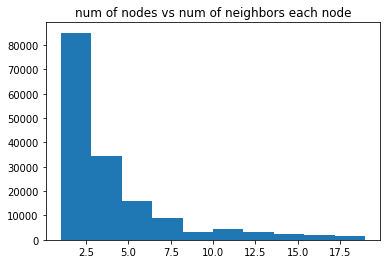

In [97]:
neig_cnt = [v for v in node2neig_cnt.values() if v < 20]
plt.title('num of nodes vs num of neighbors each node')
plt.hist(neig_cnt)
plt.show()

In [91]:
node2triangle_num = nx.triangles(connected_graph)
with open('node2tri_num.pickle', 'wb') as f_out:
    pickle.dump(node2triangle_num, f_out)

num of triangles: 614165.0


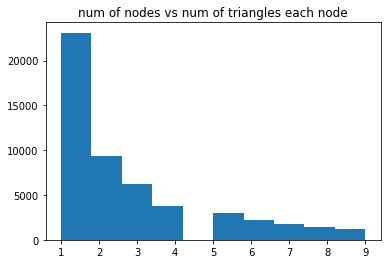

In [106]:
print('num of triangles:', sum(node2triangle_num.values()) / 3)
plt.title('num of nodes vs num of triangles each node')
plt.hist([v for v in node2triangle_num.values() if v >= 1 and v < 10])
plt.show()

In [ ]:
node_with_10_tri = {n : v for n, v in node2triangle_num.items() if v >= 5}
print(len(node_with_10_tri) / len(connected_graph.nodes))

In [57]:
def find_triangles(graph:nx.Graph, node:str):
    triangles = set()
    neighbors = set(graph.neighbors(node))
    for neighbor in neighbors:
        second_neighbors = set(graph.neighbors(neighbor))
        inter_neighbors = neighbors & second_neighbors
        for third_neighbor in inter_neighbors:
            triangles.add((node, neighbor, third_neighbor) if neighbor < third_neighbor else (node, third_neighbor, neighbor))
    return triangles

In [105]:
triangles = list(find_triangles(connected_graph, 'Machine learning'))
second_node = 'Pattern recognition'
triangles.sort(key=lambda x: x[1])
triangle_with_sents = []
n_seen = {}
for n1, n2, n3 in triangles:
    if second_node and n2 != second_node and n3 != second_node:
        continue
    if n2 not in n_seen:
        n_seen[n2] = note2line(graph.get_edge_data(n1, n2)['sent']).strip()
    if n3 not in n_seen:
        n_seen[n3] = note2line(graph.get_edge_data(n1, n3)['sent']).strip()
    sent_1 = n_seen[n2]
    sent_2 = note2line(graph.get_edge_data(n2, n3)['sent']).strip()
    sent_3 = n_seen[n3]
    triangle_with_sents.append((n1, sent_1, n2, sent_2, n3, sent_3))
with open('triangles.tsv', 'w') as f_out:
    csv_writer = csv.writer(f_out, delimiter='\t')
    csv_writer.writerows(triangle_with_sents)

## Demo

In [ ]:
# Show sentence from file
note2line('AA:00:0', '_cs.dat')

In [ ]:
# Analyze sentence
doc = nlp('these facilities enable a designer to " simulate " concurrent processes , each described using plain c + + syntax.')

# Check noun phrases in the sentences
print(list(doc.noun_chunks))

## WOE re-write

In [ ]:
kw1 = 'data mining'
kw2 = 'machine learning'
doc = nlp('Data mining is a process of extracting and discovering patterns in large data sets involving methods at the intersection of machine learning, statistics, and database systems.'.lower())
kw1_span = find_span(doc, kw1)
kw2_span = find_span(doc, kw2)
find_dependency_path_from_tree(doc, kw1_span[0], kw2_span[0])
# print(len(kw1_span))
# print(len(kw2_span))

In [ ]:
data = keyword_connection_graph.neighbors('decision tree')
my_write('neighbors.txt', list(data))

## Online operations

In [ ]:
def collect_sents_from_wiki_page(page:wikipedia.WikipediaPage):
    remove_list = ['See also', 'References', 'Further reading', 'Sources', 'External links']
    dic = {sec : page.section(sec) for sec in page.sections}
    dic['summary'] = page.summary
    sents = []
    section_list = list(dic.keys())
    while len(section_list) > 0:
        section = section_list.pop()
        if section in remove_list:
            continue
        section_text = dic[section]
        if not section_text:
            continue
        # processed_text = clean_text(section_text)
        processed_text = ' '.join(section_text.lower().split())
        temp_sents = my_sentence_tokenize(processed_text, True)
        sents += temp_sents
    return list(sents)

def collect_entity_from_wiki_page(page:wikipedia.WikipediaPage):
    return [text.lower() for text in page.links]

def collect_keyword_from_wiki_page(page:wikipedia.WikipediaPage):
    soup = BeautifulSoup(page.html(), 'html.parser')
    main_block = soup.find('div', class_='mw-parser-output')
    keywords = set([l.text.lower() for l in main_block.findAll('a') if re.match(r'^(<a href="/wiki/)', str(l))])
    return keywords



In [ ]:
keyword = 'python'

p = wikipedia.page(keyword)
if p is not None:
    sents = collect_sents_from_wiki_page(p)
    keywords = collect_keyword_from_wiki_page(p)
    print('sentences collected')
    my_write('%s.txt' % keyword, sents)
    my_write('%s_kw.txt' % keyword, keywords)
    df = filter_by_path(sents)
    df.to_csv('%s_out.tsv' % keyword, sep='\t', index=False)

    dff = df[df.apply(lambda x: str(x['head']) in keywords and str(x['tail']) in keywords, axis=1)]
    dff.to_csv('%s_out_f.tsv' % keyword, sep='\t', index=False)

In [ ]:
df['wanted'] = df.apply(lambda x: str(x['head']) in keywords, axis=1)

In [ ]:
df.head()

In [ ]:
dff.head()

In [ ]:
len(dff)

# Appendix

## Collect wikipedia page titles as entities and generate keyword list

In [ ]:
# Collect wikipedia entities and corresponding id
output = p.run(collect_wiki_entity, wiki_files)
entity_list = []
for l in output:
    entity_list += l
my_write(wikipedia_entity_file, entity_list)

In [ ]:
# Get normalized wikipedia entities
normalized_entity = []
for kw in open(wikipedia_entity_file).readlines():
    eid, ent = kw.split('\t')
    normalized_entity.append('%s\t%s' % (eid, normalize_text(ent)))
my_write(wikipedia_entity_norm_file, normalized_entity)

In [ ]:
# Generate keyword list file
keywords = [remove_brackets(line.strip().split('\t')[1]) for line in open(wikipedia_entity_norm_file)]
keywords = [kw for kw in keywords if kw.split()]
keywords = filter_specific_keywords(keywords)
keywords = list(set(keywords))
my_write(wikipedia_keyword_file, keywords)

In [ ]:
# Build wordtree
build_word_tree_v2(wikipedia_keyword_file, wikipedia_wordtree_file, wikipedia_token_file)

## Process selected dataset

In [ ]:
# Build connected graph from selected sentences(18 min) ['build_graph_from_selected']

In [ ]:
# Build connected graph from cooccurance files () ['build_graph_from_cooccur]

In [ ]:
# Load keyword connection graph in selected sentences
with open(keyword_connection_graph_file, 'rb') as f_in:
    keyword_connection_graph = pickle.load(f_in)

## Hand-crafted analysis

In [ ]:
wiki_test_df = wiki_path_test_df[wiki_path_test_df['sim'] >= 0.0]
cs_test_df = cs_path_test_df[cs_path_test_df['sim'] >= 0.0]

def match_path_pattern(path:str):
    for pp in patterns:
        if exact_match(pp, path):
            return pp
    return ''

wiki_test_df['pattern'] = wiki_test_df.apply(lambda x: match_path_pattern(x['path']), axis=1)
cs_test_df['pattern'] = cs_test_df.apply(lambda x: match_path_pattern(x['path']), axis=1)

In [ ]:
def analysis_path_result_sim_based(df:pd.DataFrame, paths:list):
    summary_df = pd.DataFrame(columns=['path', 'cnt', 'ratio', 'avg_sim'])
    for pp in paths:
        sub_df = df[df['pattern'] == pp]
        summary_df = summary_df.append({
            'path' : pp,
            'cnt' : len(sub_df),
            'ratio' : len(sub_df) / len(df),
            'avg_sim' : sum(sub_df['sim']) / len(sub_df) if len(sub_df) else 0
        }, ignore_index=True)
    summary_df = summary_df.append({
        'path' : 'general',
        'cnt' : len(df),
        'ratio' : 1,
        'avg_sim' : sum(df['sim']) / len(df) if len(df) else 0
    }, ignore_index=True)
    return summary_df

In [ ]:
analysis_path_result_sim_based(wiki_test_df, patterns)

In [ ]:
analysis_path_result_sim_based(cs_test_df, patterns)

In [ ]:
def collect_example_sent_for_pattern(df:pd.DataFrame, path:str, num:int=30, posfix:str='.dat'):
    sub_df = df[df['pattern'] == path]
    num = min(len(sub_df), num)
    sub_df = sub_df[:num]
    sub_df['sent'] = sub_df.apply(lambda x: note2line(x['sent'], posfix=posfix).strip(), axis=1)
    return sub_df

for patt in patterns:
    temp_df = collect_example_sent_for_pattern(wiki_test_df, patt)
    temp_df.to_csv('%s.tsv' % (patt[:10] if len(patt) >= 10 else patt), index=False, sep='\t')